In [25]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 
plt.style.use("science.mplstyle")

from helpers.synthesis_plots import *


dpi = 800


In [26]:
#results_dir = "/clusterfs/ml4hep/rrmastandrea/NF_results_SSS/"
#results_dir = "/global/ml4hep/spss/rrmastandrea/NF_results_SSS_6/"
results_dir = "/global/ml4hep/spss/rrmastandrea/NF_results_FETA/"

n_sig_inj = [0, 300, 500, 750, 1000, 1200, 1500, 2000, 2500, 3000]#, 3500, 4000, 4500, 5000]# 10000]
seeds = [x for x in range(3)]



# Load in


In [27]:
#x_axis = np.logspace(-8, 0, 400)
x_axis = np.linspace(1e-6, 1, 200)


#keys = ["feta", "cathode", "curtains", "salad"]
keys = ["cathode", "curtains", "salad"]


rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}                
sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
max_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}





In [17]:

for n in n_sig_inj:
    
    for seed in seeds:
        
        for k in keys:
            
            if k == "full_sup":
                tpr, sic, rejection, maxsic = get_sic_rejection(k, seed, 0, results_dir, num_bkg_events = 20000)
            else: 
                tpr, sic, rejection, maxsic = get_sic_rejection(k, seed, n, results_dir, num_bkg_events = 20000)
                
            
            interp_sic = np.interp(x_axis, tpr, sic)
            interp_rej = np.interp(x_axis, tpr, rejection)
            rejections_dict[k][n].append(interp_rej)
            sics_dict[k][n].append(interp_sic)
            max_sics_dict[k][n].append(maxsic)
            




# Take the avg

In [18]:



med_rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
med_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
med_max_sics_dict = {k:[[],[],[]] for k in keys} # mean, lower_p, upper_p
    
   

for n in n_sig_inj:
    
    for k in keys:
        
        med_rejections_dict[k][n] = get_med_percentile(rejections_dict[k][n])
        med_sics_dict[k][n] = get_med_percentile(sics_dict[k][n])
        
                 
        med_max_sics_dict[k][0].append(np.median(max_sics_dict[k][n]))
        med_max_sics_dict[k][1].append(np.percentile(max_sics_dict[k][n], 16))
        med_max_sics_dict[k][2].append(np.percentile(max_sics_dict[k][n], 84))
                        
        



for k in keys:
    med_max_sics_dict[k][0] = np.array(med_max_sics_dict[k][0])
    med_max_sics_dict[k][1] = np.array(med_max_sics_dict[k][1])
    med_max_sics_dict[k][2] = np.array(med_max_sics_dict[k][2])

In [19]:

colorblind_dict = {"full_sup":"#56B4E9",
               "salad": "#009E73",
               "feta": "#CC79A7",
               "cathode":"#D55E00",
               "curtains":"#E69F00",
                "combined": "#0072B2"}\




colors_dict = {"full_sup":"green",
               "salad": "blue",
               "feta": "purple",
               "cathode":"deeppink",
               "curtains":"orange",
                "combined": "red"}

labels_dict = {"full_sup":"Full. Sup. ",
               "salad": "SALAD",
               "feta": "FETA",
               "cathode":"CATHODE",
               "curtains":"CURTAINs",
                "combined": "Combined"}


l = 3
f_1 = 20
f_2 = 30

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


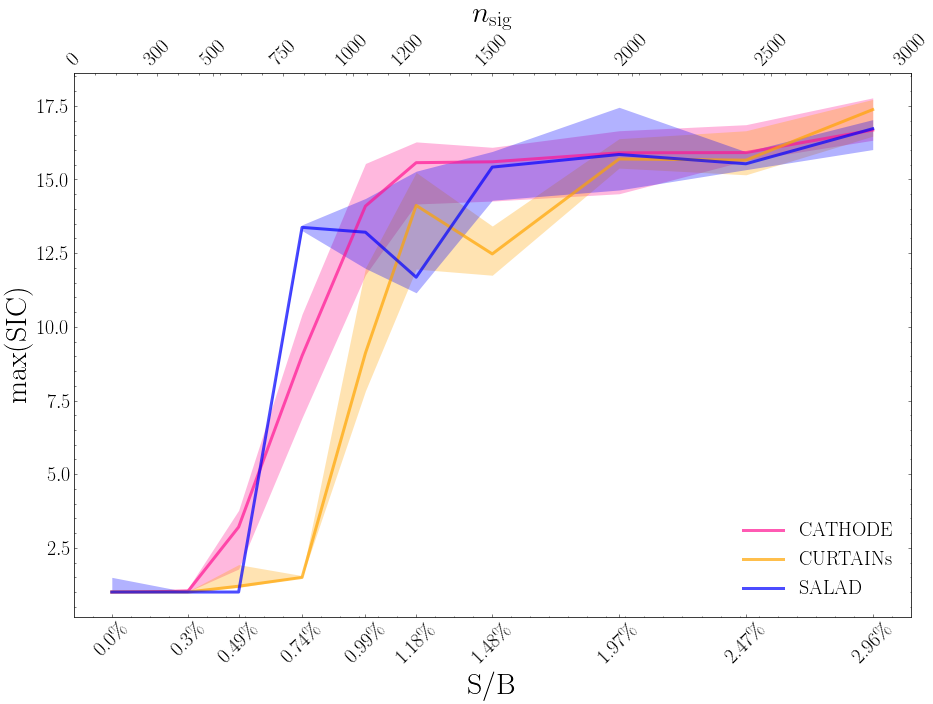

In [20]:
num_bkg = 101339

x_vals = [n / num_bkg for n in n_sig_inj]



fig = plt.figure(figsize = (15, 10)) 
for k in keys:
    
    if k == "feta": alpha = 0.3
    else: alpha = 0.3

    plt.plot(x_vals, med_max_sics_dict[k][0], label = labels_dict[k], color = colors_dict[k], linewidth = l, alpha = alpha + 0.4)

    #plt.fill_between(x_vals, mean_max_sics_dict[k][0] -mean_max_sics_dict[k][1],
    #                    mean_max_sics_dict[k][0] + mean_max_sics_dict[k][1],
     #                    alpha = alpha, color = colors_dict[k], linewidth = 0)
        
    plt.fill_between(x_vals, med_max_sics_dict[k][1],
                        med_max_sics_dict[k][2],
                         alpha = alpha, color = colors_dict[k], linewidth = 0)
   

ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax2.set_xticks(n_sig_inj)
ax2.set_xticklabels(n_sig_inj, size=f_1, rotation = 45)
ax2.set_xlabel(r"$n_\mathrm{sig}$", fontsize = f_2, labelpad = 10)


ax1.set_xticks(x_vals)
ax1.set_xticklabels([f"{np.round(100*x, 2)}\%" for x in x_vals], size=f_1, rotation = 45)
ax1.set_xlabel("S/B", fontsize = f_2)

"""
handles, labels = ax1.get_legend_handles_labels()
order = [0, 4, 1, 2, 3]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize = f_1, loc = "lower right")
"""
ax1.legend(fontsize = f_1, loc = "lower right")

ax1.set_ylabel("max(SIC)", fontsize = f_2)
ax1.tick_params(axis='both', which='major', labelsize=f_1)
fig.savefig(f"paper_plots/maxsic.pdf", dpi = dpi)

plt.show()





In [21]:
for i, n in enumerate(n_sig_inj):
    
    significance = n / np.sqrt(num_bkg)
    
    print(n, med_max_sics_dict["feta"][0][i]*significance)
    

KeyError: 'feta'

# SIC

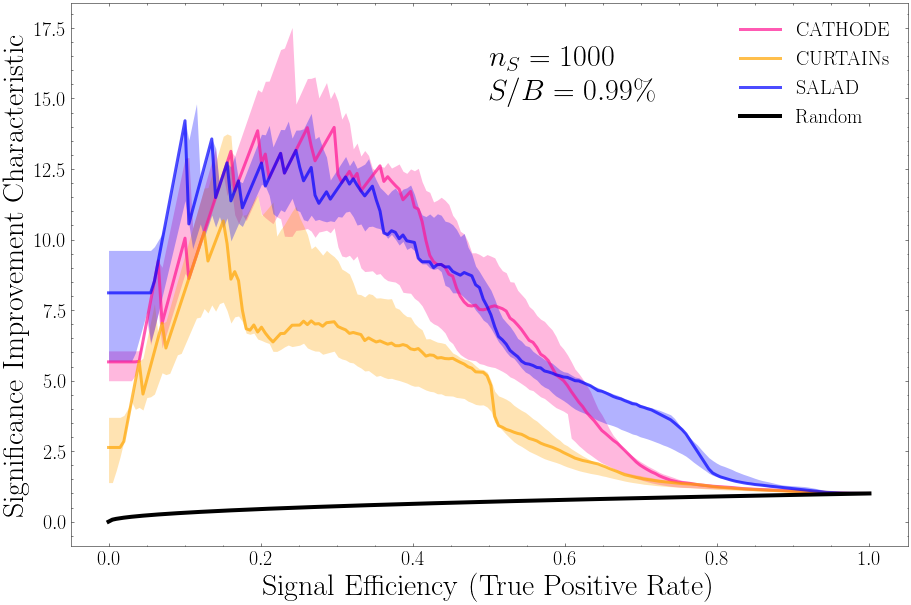

In [22]:
n_to_plot = [1000]

for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10))

    for k in keys:
        
        if k == "feta": alpha = 0.3
        else: alpha = 0.3
        
        plt.plot(x_axis, med_sics_dict[k][n][0], label = labels_dict[k], color = colors_dict[k], linewidth = l, alpha = alpha + 0.4)

        
        plt.fill_between(x_axis, med_sics_dict[k][n][1],
                         med_sics_dict[k][n][2],
                         alpha = alpha, color = colors_dict[k], linewidth = 0)
  

    plt.plot(x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black", linewidth = l+1)
    
    plt.text(0.5, 15, f"$n_S = {n}$\n$S/B = {np.round(100*n/num_bkg, 2)}\%$", fontsize = f_2)

    """
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 4, 1, 2, 3]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize = f_1)
    """
    
    plt.legend(fontsize = f_1)
    
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f_2)    
    plt.ylabel("Significance Improvement Characteristic", fontsize = f_2)
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    #plt.title(f"Num injected events: {n}")
    
    fig.savefig(f"paper_plots/sic_{n}.pdf", dpi = dpi)
    
    plt.show()

# Rejection

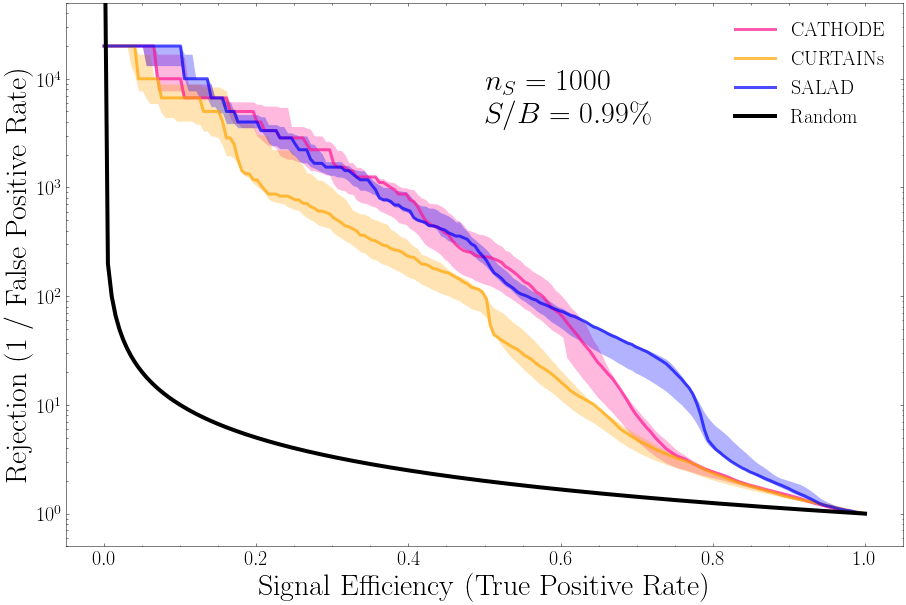

In [23]:
for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10)) 
    for k in keys:
        
        if k == "feta": alpha = 0.3
        else: alpha = 0.3
            
            
        plt.plot(x_axis, med_rejections_dict[k][n][0], label = labels_dict[k], color = colors_dict[k], linewidth = l, alpha = alpha + 0.4)

        plt.fill_between(x_axis, med_rejections_dict[k][n][1] ,
                         med_rejections_dict[k][n][2] ,
                         alpha = alpha, color = colors_dict[k], linewidth = 0)

    plt.plot(x_axis, 1.0/x_axis, label = "Random", color = "black", linewidth = l+1)
    
    plt.text(0.5, 4000, f"$n_S = {n}$\n$S/B = {np.round(100*n/num_bkg, 2)}\%$", fontsize = f_2)

    """
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 4, 1, 2, 3]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize = f_1)  
    """   
    plt.legend(fontsize = f_1)  

    
    plt.ylim(5e-1, 5e4)
    plt.yscale("log")
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f_2)  
    plt.ylabel("Rejection (1 / False Positive Rate)", fontsize = f_2)  
    #plt.title(f"Num injected events: {n}")
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    
    fig.savefig(f"paper_plots/rej_{n}.pdf", dpi = dpi)

    plt.show()

## SIC vs rej

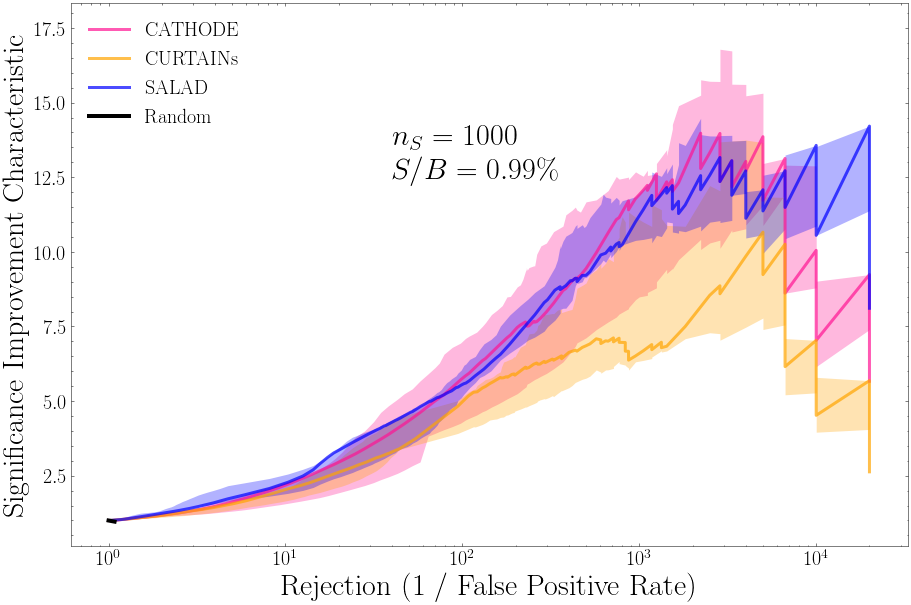

In [24]:
for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10)) 
    for k in keys:
        
        if k == "feta": alpha = 0.3
        else: alpha = 0.3
            
            
        plt.plot(med_rejections_dict[k][n][0], med_sics_dict[k][n][0], label = labels_dict[k], color = colors_dict[k], linewidth = l, alpha = alpha + 0.4)

        plt.fill_between(med_rejections_dict[k][n][0], med_sics_dict[k][n][1],
                         med_sics_dict[k][n][2] ,
                         alpha = alpha, color = colors_dict[k], linewidth = 0)

    plt.plot(1.0/x_axis[184:], x_axis[184:]/np.sqrt(x_axis[184:]), label = "Random", color = "black", linewidth = l+1)
    
    
    
    plt.text(40, 12.5, f"$n_S = {n}$\n$S/B = {np.round(100*n/num_bkg, 2)}\%$", fontsize = f_2)
    
    """
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 4, 1, 2, 3]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize = f_1)
    """

    plt.legend(fontsize = f_1)
    plt.xscale("log")
    plt.xlabel("Rejection (1 / False Positive Rate)", fontsize = f_2)  
    plt.ylabel("Significance Improvement Characteristic", fontsize = f_2)
    #plt.title(f"Num injected events: {n}")
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    fig.savefig(f"paper_plots/sic_vs_rej_{n}.pdf", dpi = dpi)
    


    plt.show()